# Regression Trees and Model Optimization - Lab

## Introduction

In this final lab, we'll see how to apply regression analysis using CART trees for regression while making use of some hyperparameter tuning to improve our model. For a comparison of predictive capabilities and computational cost, we'll work the "Boston Housing" dataset. This will allow us to compare different regression approaches in terms of their accuracy and cost involved.

## Objectives
You will be able to:
- Apply predictive regression analysis with CART trees
- Get the data ready for modeling
- Tune the key hyper parameters based a various models developed during training 
- Study the impact of tree pruning on the quality of predictions

## Boston Housing Dataset - Again ! 

The dataset is available in the repo as `boston.csv`. 

- Load the Dataset and print its head and dimensions

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('boston.csv')

# Success
print ("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

data.head()

Boston housing dataset has 506 data points with 15 variables each.


,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Identify Features and Target Data
In this lab, we shall use three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. You'll find a brief description of each predictor below:

#### Features
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

#### Target
- `MEDV`',the median value of the home.


- Create dataframes for features and target as shown above. 
- Inspect the contents for validity 

In [2]:
# Features and Target data
target = data['medv']
features = data[['rm', 'lstat', 'ptratio']]
print(data.medv.describe())
features.head()


count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64


,rm,lstat,ptratio
0,6.575,4.98,15.3
1,6.421,9.14,17.8
2,7.185,4.03,17.8
3,6.998,2.94,18.7
4,7.147,5.33,18.7


## Inspect Correlations 

- Use scatter plots to show the correlation between chosen features and target variable
- Comment on each scatter plot 

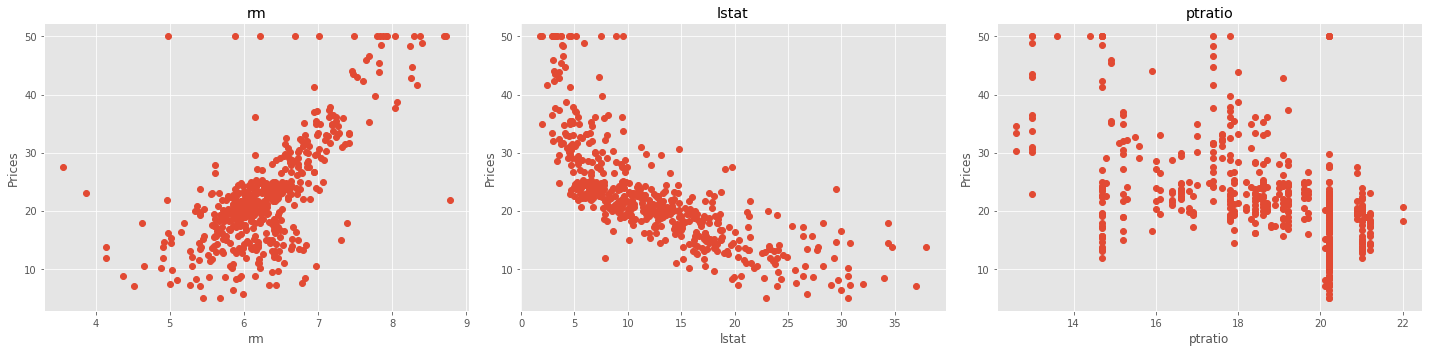

In [22]:
# Create scatter plots for each feature vs. target
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], target, 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Prices')
    plt.tight_layout()

## Create Evaluation Metrics

- Create a function `performance(true, predicted)` to calculate and return the r-sqaured score and MSE for two equal sized arrays showing true and predicted values
- TEst the function with given data 

In [5]:
# Evaluation Metrics
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 

def performance(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true,y_predict)
    mse = mean_squared_error(y_true,y_predict)
    # Return the score
    return [r2, mse]
# Calculate the performance of this model
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.4719999999999998]

[0.9228556485355649, 0.4719999999999998]

## Supervised Training 
- For supervised learning, split the `features` and `target` datasets into training/test data (80/20). 
- For reproducibility, use `random_state=42`

In [6]:
from sklearn.model_selection import train_test_split 

# Split the data into training and testing subsets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Grow a Vanilla Regression Tree

- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above.
- Use `random_state=45` for tree instance
- Record your observations

In [7]:
# Run the Model and make predictions, Evaluate 
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=45)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
score = performance(y_test, y_pred)
score[0], score[1]

# (0.4712438851035674, 38.7756862745098)  - R2, MSE

(0.47097115950374013, 38.795686274509805)

## Hyperparameter Tuning 

- Find the best tree depth for a depth range: 1-30
- Run the regressor repeatedly in a for loop for each depth value. 
- Use `random_state=45` for reproducibility
- Calculate MSE and r-squared for each run 
- Plot both performance measures, for all runs.
- Comment on the output 

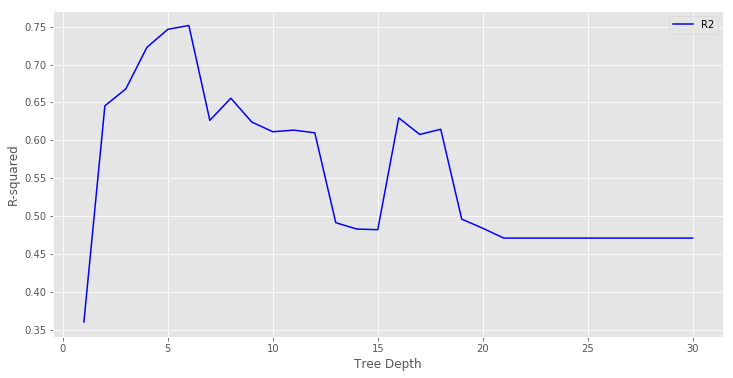

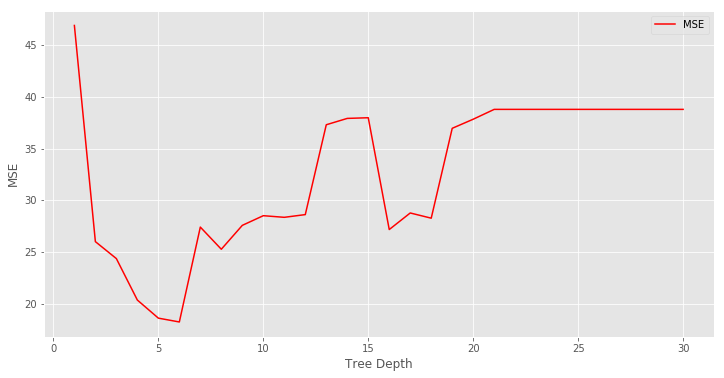

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 30, 30, endpoint=True)
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12,6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()
plt.show()
plt.figure(figsize=(12,6))
plt.plot(max_depths, mse_results, 'r', label='MSE')
plt.xlabel('Tree Depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

## More Hyperparameter Tuning 

- Repeat the above process for `min_samples_split` parameter

- Use a a range of values from 2-10 for this parameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above

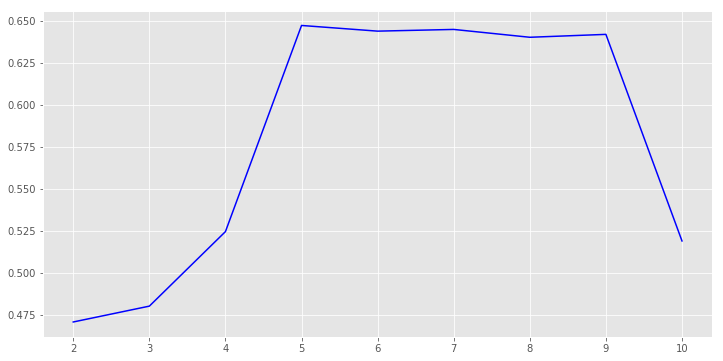

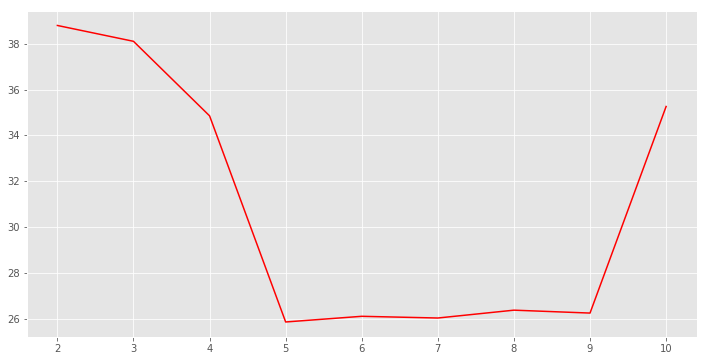

In [11]:
# Identify the optimal minimum split size for given data
min_samples_splits = np.arange(2,11)
mse_results = []
r2_results = []

for min_samples_split in min_samples_splits:
    regressor = DecisionTreeRegressor(min_samples_split=int(min_samples_split), random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, r2_results, 'b', label='R2')
plt.show()
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, mse_results, 'r', label='MSE')
plt.show()

# Run the "Optimized" Model 

- Use the best values for max_depth and min_samples_split found in previous runs and run an optimized model with these values. 
- Calculate the performance and comment on the output 

In [13]:
regressor = DecisionTreeRegressor(min_samples_split=6, max_depth=6, random_state=45)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
score = performance(y_test, y_pred)
score[0], score[1], regressor

(0.7510017608643338,
 18.259982876077185,
 DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=45, splitter='best'))

## Level Up - Optional 

- How about bringing in some more features from the original dataset which may be good predictors?
- Also , try tuning more hyperparameters like max-features to find the optimal version of the model.


## Summary 

In this lab, we looked at applying a decision tree based regression analysis on the Boston Housing Dataset. We saw how to train various models to find the optimal values for pruning and limiting the growth of the trees. We also looked at how to extract some rules from visualizing trees , that might be used for decision making later.